In [1]:
from __future__ import  division
import numpy as np
import pandas as pd
from collections import OrderedDict
import sys
import os
import re
import gzip
import pickle

from scipy.stats import percentileofscore
from scipy.stats import  mannwhitneyu
from inspect import signature
from sklearn.metrics import roc_curve, auc,  precision_recall_curve
from scipy import  interp
from scipy.interpolate import  interp1d
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
########################################################################################
## FUNCTIONS
def geneID_to_name(x , lookup ):
    try:
        rval =  lookup[x]
    except KeyError:
        rval = np.nan
    return rval
  

def permTest_stochasticallyGreater( data, group_col, condition_col, value_col, group_names, n_perm, return_null_stats = False, two_sided = False):
    """Test if one group is stochastically greater than another only considering those value pairs with the 
    same condition label.
    Arguments:
        data - pd.DataFrame of observations
        group_col - column whose values indicte group identity
        codition_col- column whose values indice condition identity
        value_col - column storing values to be compared
        n_perms - number of permutations for determining pvalue
        group_names - length 2  list of values of group_col to compare. The test is that the first is GREATER than the second
    """
    wins = data.groupby(condition_col).apply( lambda x: (x.loc[x[group_col]==group_names[0], value_col ].values[:,None] - \
                                                       x.loc[x[group_col]==group_names[1], value_col ].values[None, :] > 0 ).sum() ).sum()
    attempts = data.groupby(condition_col).apply(lambda x: len( x.loc[x[group_col]==group_names[0],value_col] )*len( x.loc[x[group_col]==group_names[1],value_col])).sum()  
    test_stat = wins / attempts 
    
    condition_vals = data[condition_col].unique()
    null_stats = []
    for perm_idx in range(n_perm):
        if perm_idx % 1000 ==0:
            print(perm_idx)
        wins = 0
        attempts = 0
        for condition_val in condition_vals:
            perm_df = data.loc[ data[condition_col] == condition_val, :].copy()
            group_labels=  np.copy(perm_df[group_col].values)
            perm_df[group_col] = np.random.permutation(group_labels)
            diffs =  perm_df.loc[ perm_df[group_col ]  == group_names[0], value_col].values[:,None] - \
                         perm_df.loc[ perm_df[group_col]  == group_names[1], value_col].values[None, :]
            wins = wins + np.sum(diffs > 0)
            attempts = attempts + np.product(diffs.shape)
        null_stats.append(wins / attempts)
    if two_sided:
        p_val = 2.*min( percentileofscore(null_stats , test_stat)/100., 1. - percentileofscore(null_stats , test_stat)/100.)  ## this assumes null distribution is symmetric 
    else:
        p_val = 1. - percentileofscore(null_stats , test_stat)/100.
    if return_null_stats:
        return test_stat, p_val , null_stats
    else:
        return test_stat, p_val 

In [4]:
class GO_SE( object ):
    """Assess and plot score enrichment of GO annotated genes
    """
    def __init__(self, ):
        """
        """
        self.data_raw = OrderedDict([])
        self.perform_by_fold = OrderedDict([])
        self.perform_agg_fold = None

    def add_performance(self , data, model_id, fpr_vals =  np.linspace(0., 1., 100)   ):
        """
        data - pd.DataFrame columns - [ "fold", "y_true", "y_pred" , "isGO"]
                             index - one entry for the test set elements of each fold. Test sets should be disjoint.
                             Note: y_true must be 0's and 1's only. Test are done for performance in predicting class labeled by 1.
        model_id - label for accessing results
        
        """
        self.data_raw[model_id] = data.copy()
        folds = sorted(data["fold"].unique())
        
        perform_df = pd.DataFrame( index = fpr_vals,
                                  columns = pd.MultiIndex.from_product( [["tpr" , "n_GO" , "n_notGO"] , folds] ),
                                  data = -1.)
        for fold in folds:
            y_true = data.loc[ data["fold"] == fold , "y_true" ].values.copy()
            y_pred = data.loc[ data["fold"] == fold , "y_pred" ].values.copy()
            isGO =  data.loc[ data["fold"] == fold , "isGO" ].values.copy()
            fpr , tpr, thresh = roc_curve( y_true = y_true, y_score = y_pred)
            n_GO = np.array([ np.sum(isGO[ (y_pred >= t)&(y_true == 1.)]) for t in  thresh ]) 
            n_notGO = np.array([ np.sum( np.logical_not(isGO[ (y_pred >= t)&(y_true == 1.)])  ) for t in  thresh ]) 
            
            perform_df[("tpr", fold) ]=  interp(fpr_vals, xp = fpr  , fp = tpr )
            perform_df.loc[0.,("tpr", fold)]  = 0.0  ## this is done in sklearn demo 
            
            n_GO_interp =  interp1d( *GO_SE.dedup_xvals(fpr ,n_GO),  kind='previous') # dedup_xvals always selects the largest number of Go genes correctly called at fpr thresh
            perform_df[("n_GO", fold)] = n_GO_interp(fpr_vals)
          
            n_notGO_interp =  interp1d( *GO_SE.dedup_xvals(fpr , n_notGO),  kind='previous')  ## dedup_xvals always selects the largest number of notGo genes correctyl called at fdr thresh
            perform_df[("n_notGO", fold)] = n_notGO_interp(fpr_vals)
            
        self.perform_by_fold[model_id] = perform_df
        return None
    @staticmethod
    def dedup_xvals(x_vals , y_vals):
        x_uniq = np.unique(x_vals)
        y_uniq = []
        for x in x_uniq:
            mask = x_vals == x
            y_uniq.append(np.max( y_vals[mask]) )
        return x_uniq , np.array(y_uniq)
    def aggregate_folds(self, bw = 0.1 ):
        
        self.perform_agg_fold = OrderedDict([])
        for model_id, perform_df in self.perform_by_fold.items():
            perform_df_summary = pd.DataFrame( index = perform_df.index , 
                                              columns = ["tpr_mean",  "tpr_CI_lower",  "tpr_CI_upper", "n_GO" , "n_notGO", "CDF_GO" , "CDF_notGO", "PDF_GO" , "PDF_notGO"], data = -1. )
            perform_df_summary["tpr_mean"] = perform_df["tpr"].mean(axis = 1)
            tpr_std = perform_df["tpr"].std(axis = 1)
            n_folds = perform_df["tpr"].shape[1]
            perform_df_summary["tpr_CI_upper"] = np.minimum( perform_df_summary["tpr_mean"] + (tpr_std/np.sqrt(n_folds))*1.96 , 1. )
            perform_df_summary["tpr_CI_lower"] = np.maximum( perform_df_summary["tpr_mean"] - (tpr_std/np.sqrt(n_folds))*1.96 , 0. )
            
            perform_df_summary["n_GO"] = perform_df["n_GO"].sum( axis = 1 )
            perform_df_summary["CDF_GO"] = perform_df_summary["n_GO"] /  perform_df_summary["n_GO"].values[-1]
            perform_df_summary["PDF_GO"] = GO_SE.cdf_to_pdf( x_vals = perform_df_summary.index.values, x_samples =perform_df_summary.index.values,  
                                                            cdf =  perform_df_summary["CDF_GO"].values , bw = bw)
            
            perform_df_summary["n_notGO"] = perform_df["n_notGO"].sum( axis = 1 )
            perform_df_summary["CDF_notGO"] = perform_df_summary["n_notGO"] /  perform_df_summary["n_notGO"].values[-1]
            perform_df_summary["PDF_notGO"] = GO_SE.cdf_to_pdf( x_vals = perform_df_summary.index.values, x_samples =perform_df_summary.index.values,  
                                                            cdf =  perform_df_summary["CDF_notGO"].values , bw = bw)
            self.perform_agg_fold[model_id] = perform_df_summary
        return None
    
    def rename_model_ids(self, name_dict ):
        """
        name_dict = {old: new}
        """
        self.data_raw = OrderedDict([ (name_dict[k], v ) if k in name_dict.keys() else  (k,v) for k,v in  self.data_raw.items() ])
        self.perform_by_fold = OrderedDict([ (name_dict[k], v ) if k in name_dict.keys() else  (k,v) for k,v in  self.perform_by_fold.items() ])
        self.perform_agg_fold =  OrderedDict([ (name_dict[k], v ) if k in name_dict.keys() else  (k,v) for k,v in  self.perform_agg_fold.items() ])
        return None
    
    @staticmethod
    def cdf_to_pdf( x_vals, x_samples , cdf, bw ):
    
        pmf =  np.diff(np.concatenate( [np.array([0.]) , cdf])  )
        pdf_smooth = GO_SE.smooth_normalWeights( x_vals, x_samples, pmf = pmf , bw=bw , x_lim = (0,1) )
        return  pdf_smooth
    
    @staticmethod 
    def smooth_normalWeights(x_vals, x_signal, pmf , bw, x_lim = (0,1) ):
        """Get KDE estimate of PDF from a normalized histogram. renomalizing kernal for edge effects
        pdfSmoothed_j = \sum_{x_j} pmf_j \frac{S(x-x_j)}{\int_{0 - x_j}^{1-x_j} S(\xi) d\xi  }
        Inputs
        ------
            x_vals - Random variable values at which pdf estimate is returned
            x_signal - bin coordinates for histogram
            pmf - probablility mass of histogram bins
            bw - bandwidth (std) for gaussian kernel 
            x_lim - lower and upper bounds for support
        Returns
            pdf_smoothed - array with same shape as x_vals
        """
        pdf_smoothed = -1.*np.ones(len(x_vals))
        for i ,x in enumerate(x_vals):
            weights = norm.pdf( ( x_signal-x), scale = bw) / ( norm.cdf(x_lim[1] -x_signal , scale = bw) -  norm.cdf(x_lim[0] - x_signal , scale = bw)  ) 
            smoothed =  np.dot( weights , pmf )
            pdf_smoothed[i] = smoothed 
        return pdf_smoothed
            
    def test_enrichment(self, model_ids = None ):
        """
        """
        if model_ids is None:
            model_ids = list(self.data_raw.keys() )
        test_df  = pd.DataFrame(index = model_ids , columns = ["mw_stat" , "p" , "p_adj", "n_isGo", "n_notGO"] , data = -1. )
        for model_id in  model_ids:
            data = self.data_raw[model_id]
            folds = sorted(data["fold"].unique() )
            FPRs_isGO = []
            FPRs_notGO = []
            for fold in folds:
                data_class0 =  data.loc[ (data["fold"] == fold ) & ( data["y_true"] == 0) , : ].copy()
                data_class1 =  data.loc[ (data["fold"] == fold ) & ( data["y_true"] == 1) , : ].copy()
                FPRs_isGO.extend( list(data_class1.loc[ data["isGO"], "y_pred"].map( 
                                        lambda x:  np.sum(data_class0["y_pred"].values >= x) / data_class0.shape[0] ).values ) )
                FPRs_notGO.extend( list( data_class1.loc[ ~data["isGO"], "y_pred"].map(
                                        lambda x:  np.sum(data_class0["y_pred"].values >= x) / data_class0.shape[0] ).values) )
                    
            stat,  p = mannwhitneyu( FPRs_isGO , FPRs_notGO, alternative = "two-sided")
            test_df.loc[model_id, ["mw_stat" , "p", "p_adj", "n_isGo", "n_notGO"] ] = stat, p, p*len(model_ids), len(FPRs_isGO ) , len(FPRs_notGO)
                             
        return  test_df        

    def plot_ROC(self, palette_model_id, ax =None,  figsize = None, model_ids = None,
                 xlabel = "False Positive Rate" , ylabel = "True Positive Rate", lw =4, alpha = 0.15):
        
        if ax is None:
            fig , ax = plt.subplots(figsize = figsize)
        if model_ids is None:
            model_ids = list(self.perform_agg_fold.keys() )
        for model_id in  model_ids:
            xvals = self.perform_agg_fold[model_id].index.values
            yvals = self.perform_agg_fold[model_id]["tpr_mean"].values
            ax.plot(  xvals ,  yvals , color = palette_model_id[model_id], label = model_id, lw = lw)
            ax.fill_between( xvals ,
                            self.perform_agg_fold[model_id]["tpr_CI_lower"].values , 
                            self.perform_agg_fold[model_id]["tpr_CI_upper"].values ,  
                            color =  palette_model_id[model_id], alpha = alpha )

            ax.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
        ax.legend(ncol = 2)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        return ax
    
    def plot_GOSE(self, palette_model_id, ax =None,  figsize = None, model_ids = None, 
                 xlabel = 'False Positive Rate' , ylabel = r'$\log_2(\frac{\mathrm{Density\ GO\ enriched}}{\mathrm{Density\ not\ GO\ enriched}})$', lw =4, alpha = 0.15,
                 legend = True):
        if ax is None:
            fig , ax = plt.subplots(figsize = figsize)
        if model_ids is None:
            model_ids = list(self.perform_agg_fold.keys() )
        for model_id in  model_ids:
            y_vals = np.log2(self.perform_agg_fold[model_id]["PDF_GO"]  /  self.perform_agg_fold[model_id]["PDF_notGO"] )
            x_vals = self.perform_agg_fold[model_id].index.values
            ax.plot(x_vals ,  y_vals ,  color = palette_model_id[model_id], label = model_id, lw = lw )
            
        ax.axhline(0.0 , color = 'k', ls = "--")
        if legend:
            ax.legend()
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        return ax
            
    def plot_ROCandGOSE(self, palette_model_id, figsize = (3.5, 5),  ):
        
        fig = plt.figure(figsize = figsize)
        ax_roc = fig.add_axes([0.05 , 0.33 , 0.95, 0.67])
        ax_roc = self.plot_ROC( palette_model_id, ax =ax_roc , figsize = None, model_ids = None,
                             xlabel = "" , ylabel = "True Positive Rate", lw =2, alpha = 0.15)
        ax_roc.set_xticklabels([])
        ax_GO = fig.add_axes([0.05 , 0.0 , 0.95, 0.3])
        ax_GO = self.plot_GOSE( palette_model_id, ax =ax_GO,  figsize = None, model_ids = None,
                                lw =2, alpha = 0.15, legend = False)
        return fig
        


## Notes on KDE smoothing in `GO_SE.smooth_normalWeights`

Inputs are 
x_vals 
x_samples 
pmf
bw=bw 
x_lim = (0,1)

For each x $\in$ x_vals the pdf estimate is

$$
\textrm{pdf_smoothed}_j = \sum_{x_j} \textrm{pmf}_j \frac{S(x-x_j)}{\int_{0 - x_j}^{1-x_j} S(\xi) d\xi  }
$$

In [14]:
########################################################################################
## Globals
fi_david_chart = [ "../cellResponse/GO/3B13L-d1_DEgenes_down-chartAnnot.tsv,../cellResponse/GO/3B13L-d1_DEgenes_up-chartAnnot.tsv", 
"../cellResponse/GO/3B13L-d2_DEgenes_down-chartAnnot.tsv,../cellResponse/GO/3B13L-d2_DEgenes_up-chartAnnot.tsv"  ,
"../cellResponse/GO/3B13L-d3_DEgenes_down-chartAnnot.tsv,../cellResponse/GO/3B13L-d3_DEgenes_up-chartAnnot.tsv" ,
"../cellResponse/GO/3B13L-d4_DEgenes_down-chartAnnot.tsv,../cellResponse/GO/3B13L-d4_DEgenes_up-chartAnnot.tsv" ]
labels_david_chart = ["d1" , "d2" , "d3" , "d4"]

fi_preds = ["./CV_d.plus0_DE.down_v_rest_preds.test.tsv.gz", "./CV_d.plus0_DE.up_v_rest_preds.test.tsv.gz"  ]
fi_geneID_to_name = "../cellResponse/geneNames.proper.tsv"

In [15]:
######################################################################################
## LOAD DATA
DAVID_out = OrderedDict([])
for fnames, label in zip(fi_david_chart, labels_david_chart):
    f_down , f_up =  fnames.split(",")
    df_down = pd.read_csv( f_down, sep = "\t" , usecols=[0,1,5,11] )
    df_down["Categ_and_term" ] =  df_down.apply( lambda x: x["Category"] + "__" + x["Term"], axis = 1 ) 
    df_up = pd.read_csv( f_up, sep = "\t" , usecols=[0,1,5,11] )
    df_up["Categ_and_term" ] =  df_up.apply( lambda x: x["Category"] + "__" + x["Term"], axis = 1 ) 
    DAVID_out[label] = {"down" : df_down , "up" :df_up }

## Restrict to KEGG_PATHWAY and Biological processes
for k1 in DAVID_out.keys():
    for k2 in DAVID_out[k1].keys():  ## "GOTERM_BP_DIRECT"
        DAVID_out[k1][k2] = DAVID_out[k1][k2].loc[ DAVID_out[k1][k2]["Category"].map(lambda x: x in [ "KEGG_PATHWAY", "GOTERM_BP_DIRECT"] ),: ].copy() 
## Get GO enriched DE genes by day and DE direction
GO_enriched_genes = OrderedDict([ (condition , {"down": [] , "up": []}) for condition in  DAVID_out.keys()  ])
for cond in GO_enriched_genes.keys():
    for direction in GO_enriched_genes[cond].keys():
        GO_enriched_genes[cond][direction] =  set([ x.strip() for gene_list in  DAVID_out[cond][direction]["Genes"] for x in  gene_list.split(",") ] )
    
geneName_lookup = pd.read_csv(fi_geneID_to_name, header = 0, sep = "\t")
geneName_lookup = geneName_lookup.set_index("geneID", verify_integrity = True)

preds = {"DE.down_v_rest" : pd.read_csv( fi_preds[0] , sep = "\t", index_col= 0) , "DE.up_v_rest" : pd.read_csv( fi_preds[1] , sep = "\t", index_col= 0)}
preds["DE.down_v_rest"] =  preds["DE.down_v_rest"].loc[ preds["DE.down_v_rest"]["penalty"]   == 0.01 , :].drop(columns = "penalty")
preds["DE.up_v_rest"] =  preds["DE.up_v_rest"].loc[ preds["DE.up_v_rest"]["penalty"]   == 0.01 , :].drop(columns = "penalty")


## Associated gene symbols, log likelihoods and  with predictions
for k in preds.keys():
    k_to_dir = {"DE.down_v_rest" : "down" , "DE.up_v_rest" : "up"  }
    
    preds[k]["geneName"] = preds[k]["geneID"].map(lambda x : geneID_to_name(x , geneName_lookup["geneSymb"] ) )
    preds[k]["isGO"] = preds[k].apply( lambda x : x["geneName"] in GO_enriched_genes[x["day"]][k_to_dir[k]], axis = 1  )

In [16]:
geneName_lookup.head()

,geneSymb,ORF,SGD_id
geneID,,,
gene10,YCT1,YLL055W,S000003978
gene100,STT4,YLR305C,S000004296
gene1000,TAM41,YGR046W,S000003278
gene1001,TID3,NaN,NaN
gene1002,SSL2,YIL143C,S000001405


In [17]:
display(preds["DE.down_v_rest"].head())
display(preds["DE.up_v_rest"].head())

,cls_name,fold,geneID,stdz_name,train/test,y,model_out,day,geneName,isGO
63132,class0,0,gene3913,d1,test,0,0.296910,d1,SVF1,False
63133,class0,0,gene3790,d1,test,0,0.307125,d1,NCS6,False
63134,class0,0,gene628,d1,test,0,0.291679,d1,RPN5,False
63135,class0,0,gene2187,d1,test,0,0.323658,d1,PAN3,False
63136,class0,0,gene737,d1,test,0,0.289388,d1,NaN,False


,cls_name,fold,geneID,stdz_name,train/test,y,model_out,day,geneName,isGO
63132,class0,0,gene91,d1,test,0,0.366436,d1,YOR022C,False
63133,class0,0,gene14,d1,test,0,0.347813,d1,NaN,False
63134,class0,0,gene2364,d1,test,0,0.340918,d1,YGL159W,False
63135,class0,0,gene4972,d1,test,0,0.330997,d1,PHO23,False
63136,class0,0,gene4111,d1,test,0,0.296944,d1,ROG1,False


In [18]:
## Write summary
print("Summary of genes with GO enrichment")
for cond in  GO_enriched_genes.keys():
    for direction in GO_enriched_genes[cond].keys():
        print("\tcondtion: {}, direction: {}, number genes with GO enriched term: {}".format(cond, direction, len(GO_enriched_genes[cond][direction]) ) )
        
for direction in preds.keys():
    print("Direction: {}".format(direction))
    print( "\tNumber GO day 1 {}".format( preds[direction].loc[ preds[direction]["day"] =="d1" ,  "isGO" ].sum() ) )
    print( "\tNumber GO day 2 {}".format(  preds[direction].loc[ preds[direction]["day"] =="d2" ,  "isGO" ].sum() ) )
    print( "\tNumber GO day 3 {}".format(  preds[direction].loc[ preds[direction]["day"] =="d3" ,  "isGO" ].sum() ) )
    print( "\tNumber GO day 4 {}".format(  preds[direction].loc[ preds[direction]["day"] =="d4" ,  "isGO" ].sum() ) )

Summary of genes with GO enrichment
	condtion: d1, direction: down, number genes with GO enriched term: 396
	condtion: d1, direction: up, number genes with GO enriched term: 555
	condtion: d2, direction: down, number genes with GO enriched term: 263
	condtion: d2, direction: up, number genes with GO enriched term: 479
	condtion: d3, direction: down, number genes with GO enriched term: 117
	condtion: d3, direction: up, number genes with GO enriched term: 162
	condtion: d4, direction: down, number genes with GO enriched term: 38
	condtion: d4, direction: up, number genes with GO enriched term: 98
Direction: DE.down_v_rest
	Number GO day 1 396
	Number GO day 2 263
	Number GO day 3 117
	Number GO day 4 38
Direction: DE.up_v_rest
	Number GO day 1 555
	Number GO day 2 479
	Number GO day 3 162
	Number GO day 4 98


In [19]:
plt.rcParams["axes.labelsize"] = "large"
plt.rcParams["legend.fontsize"] = "x-large"
plt.rcParams["xtick.labelsize"] = "x-large"
plt.rcParams["ytick.labelsize"] = "large"

preds_df =preds["DE.down_v_rest"].copy()
bw = 0.1
palette =  OrderedDict([ ("Day "+str(i), sns.color_palette("Blues",5)[i]) for i in range(1,5)])

assert( (preds_df["train/test"] == "test").all() )
preds_df = preds_df.drop( columns = ["cls_name" , "geneID" , "stdz_name" , "train/test" , "geneName"] )
preds_df = preds_df.rename(columns = {"y" : "y_true", "model_out":"y_pred"})


go_se = GO_SE()
for d in ["d1" , "d2" , "d3" , "d4"]:
    go_se.add_performance( data = preds_df.loc[preds_df["day"] ==d , : ].drop(columns = ["day"]) , 
                          model_id =d ,
                          fpr_vals =  np.linspace(0., 1., 100) )
go_se.aggregate_folds(bw = bw )

100
100
100
100
100
100
100
100


In [10]:
go_se.rename_model_ids({"d1" : "Day 1" , "d2" : "Day 2" , "d3" : "Day 3" , "d4" : "Day 4"})

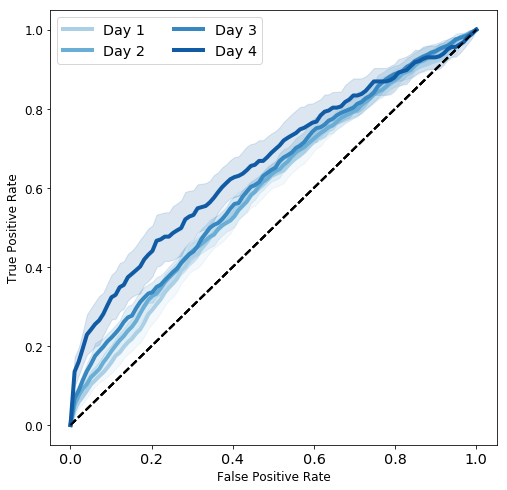

In [11]:
go_se.plot_ROC(palette_model_id = palette , figsize = (8,8))

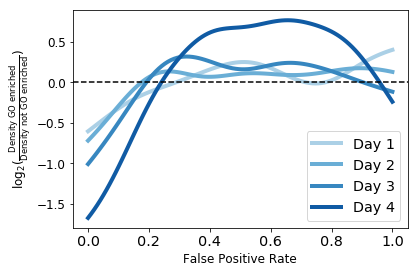

In [12]:
go_se.plot_GOSE( palette_model_id  = palette )

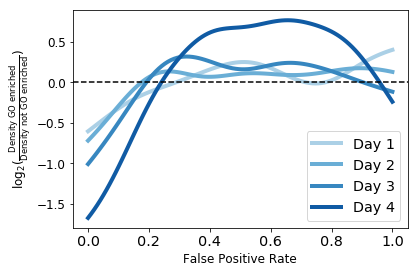

In [12]:
go_se.plot_GOSE( palette_model_id  = palette )

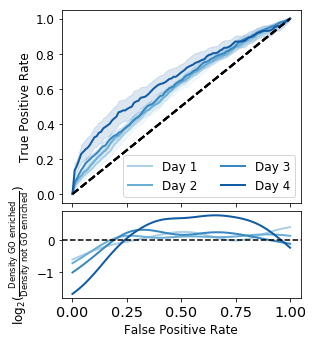

In [13]:
plt.rcParams["axes.labelsize"] = "large"
plt.rcParams["legend.fontsize"] = "large"
plt.rcParams["xtick.labelsize"] = "x-large"
plt.rcParams["ytick.labelsize"] = "large"

fig = go_se.plot_ROCandGOSE(palette_model_id = palette, figsize = (3.5, 4),  )

fig.savefig( "./CV.downVrest_ROC_GO.FPR.enrichment.pdf" , format = "pdf", bbox_inches = "tight" )

In [14]:
test_enrichStats =  go_se.test_enrichment()
display(test_enrichStats)
test_enrichStats.to_csv("./CV.downVrest_ROC_GO.FPR.enrichment.stats.tsv", sep = "\t")

,mw_stat,p,p_adj,n_isGo,n_notGO
Day 1,289270.5,0.008404,0.033615,396.0,1344.0
Day 2,171879.5,0.036908,0.147632,263.0,1208.0
Day 3,49811.5,0.054753,0.219011,117.0,767.0
Day 4,6754.5,0.004003,0.016011,38.0,276.0


In [17]:
plt.rcParams["axes.labelsize"] = "large"
plt.rcParams["legend.fontsize"] = "x-large"
plt.rcParams["xtick.labelsize"] = "x-large"
plt.rcParams["ytick.labelsize"] = "large"

preds_df =preds["DE.up_v_rest"].copy()
bw = 0.1
palette =  OrderedDict([ ("Day "+str(i), sns.color_palette("Reds",5)[i]) for i in range(1,5)])

assert( (preds_df["train/test"] == "test").all() )
preds_df = preds_df.drop( columns = ["cls_name" , "geneID" , "stdz_name" , "train/test" , "geneName"] )
preds_df = preds_df.rename(columns = {"y" : "y_true", "model_out":"y_pred"})


go_se = GO_SE()
for d in ["d1" , "d2" , "d3" , "d4"]:
    go_se.add_performance( data = preds_df.loc[preds_df["day"] ==d , : ].drop(columns = ["day"]) , 
                          model_id =d ,
                          fpr_vals =  np.linspace(0., 1., 100) )
go_se.aggregate_folds(bw = bw )

In [18]:
go_se.rename_model_ids({"d1" : "Day 1" , "d2" : "Day 2" , "d3" : "Day 3" , "d4" : "Day 4"})

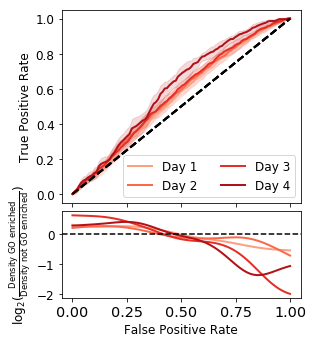

In [21]:
plt.rcParams["axes.labelsize"] = "large"
plt.rcParams["legend.fontsize"] = "large"
plt.rcParams["xtick.labelsize"] = "x-large"
plt.rcParams["ytick.labelsize"] = "large"

fig = go_se.plot_ROCandGOSE(palette_model_id = palette, figsize = (3.5, 4),  )

fig.savefig( "./CV.upVrest_ROC_GO.FPR.enrichment.pdf" , format = "pdf", bbox_inches = "tight" )


In [22]:
test_enrichStats =  go_se.test_enrichment()
display(test_enrichStats)
test_enrichStats.to_csv("./CV.upVrest_ROC_GO.FPR.enrichment.stats.tsv", sep = "\t")


,mw_stat,p,p_adj,n_isGo,n_notGO
Day 1,277673.0,0.000378,0.001510,555.0,1120.0
Day 2,230611.0,0.009177,0.036710,479.0,1050.0
Day 3,43427.5,0.000009,0.000035,162.0,691.0
Day 4,12376.5,0.010468,0.041874,98.0,305.0
